In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import tensornetwork as tn
tn.set_default_backend("jax")
import jax.numpy as jnp
import jax
from jax import grad, jit, vmap, random

import copy
from jax.scipy.special import logsumexp
import math

In [2]:
from jax.config import config
config.update("jax_enable_x64", True)

In [3]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize
x_train, x_test = x_train / 255.0, x_test / 255.0

In [4]:
def pooling(data):
    xlen = np.int(data.shape[1]/2)
    ylen = np.int(data.shape[2]/2)
    arr = np.zeros((data.shape[0], xlen, ylen))
    for i in range(0, data.shape[1], 2):
        for j in range(0, data.shape[2], 2):
            for k in range(0, data.shape[0]):
                arr[k][np.int(i/2)][np.int(j/2)] = \
                (data[k][i][j]+data[k][i+1][j]+data[k][i][j+1]+data[k][i+1][j+1])/4
    return arr

In [5]:
x_train_pool = pooling(x_train)
x_test_pool = pooling(x_test)

In [6]:
num_labels = 10

x_train = jnp.array(x_train_pool, dtype=jnp.float64)
x_test = jnp.array(x_test_pool, dtype=jnp.float64)

num_pixels = x_train.shape[1] * x_train.shape[2]
x_train_1d = jnp.reshape(x_train, (x_train.shape[0], num_pixels))
x_test_1d = jnp.reshape(x_test, (x_test.shape[0], num_pixels))

/home/ryunagai/virtualenvs/jax_cpu/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [7]:
def one_hot(x, k, dtype=jnp.float64):
    """Create a one-hot encoding of x of size k."""
    return jnp.array(x[:, None] == jnp.arange(k), dtype)

y_train_1h = one_hot(y_train, num_labels)
y_test_1h = one_hot(y_test, num_labels)

### Functions for Tensor Network

In [8]:
def feature_map(p):
    phi = jnp.array([1-p, p])
    return phi

def data_tensorize(vec):
    data_tensor = [tn.Node(feature_map(p)) for p in vec]
    return data_tensor

In [68]:
def block(*dimensions):
    '''Construct a new matrix for the MPS with random numbers from 0 to 1'''
    seed = np.random.randint(100)
    key = random.PRNGKey(seed)
    size = tuple([x for x in dimensions])
    scale = 0.35
    return scale * random.normal(key, size, dtype=jnp.float64)

def create_blocks(rank, dim, bond_dim, label_dim):
    half = jnp.array([(rank - 2) / 2], dtype = jnp.int32)[0]
    blocks = [
        block(dim, bond_dim) ] + \
        [ block(bond_dim, dim, bond_dim) for _ in range(half)] + \
        [ block(bond_dim, label_dim, bond_dim) ] + \
        [ block(bond_dim, dim, bond_dim) for _ in range(half, rank-2)] + \
        [ block(bond_dim, dim) 
        ]
    return blocks

def create_MPS_labeled(blocks, rank, dim, bond_dim):
    '''Build the MPS tensor'''
    #half = jnp.array([(rank - 2) / 2], dtype = jnp.int32)[0]
    mps = []
    for b in blocks:
        mps.append(tn.Node(b))

    #connect edges to build mps
    connected_edges=[]
    conn=mps[0][1]^mps[1][0]
    connected_edges.append(conn)
    for k in range(1,rank):
        conn=mps[k][2]^mps[k+1][0]
        connected_edges.append(conn)

    return mps, connected_edges

### Prediction function

In [71]:
label_len = 1
label_dim = 10
data_len = x_train_1d.shape[1]
rank = data_len
dim = 2
bond_dim = 10

blocks = create_blocks(rank, dim, bond_dim, label_dim)

@jit
def predict_2(data, blocks):
    data = [jnp.array([[1-p], [p]]) for p in data]
    half = math.floor(len(data)/2)
    mps = []
    dims = []
    mps += [data[0], blocks[0], blocks[1]]
    dims += [(1, -1), (1, 2), (2, 3, 4)]
    closed = 3
    opened = -2
    for i in range(1, half):
        mps += [data[i], blocks[i+1]]
        if i==half-1:
            dims += [(closed, opened), (closed+1, opened-1, closed+3)]
            opened -= 1
        else:
            dims += [(closed, opened), (closed+1, closed+2, closed+3)]
        closed += 2
        opened -= 1
    for j in range(half, len(data)-1):
        mps += [blocks[j+1], data[j]]
        dims += [(closed+1, closed+2, closed+3), (closed+2, opened)]
        closed += 2
        opened -= 1
    mps += [blocks[len(data)], data[-1]]
    dims += [(closed+1, closed+2), (closed+2, opened)]
    res = tn.ncon(mps, dims)
    res = jnp.squeeze(res)
    res = res - logsumexp(res)
    return res

def data_list(vec):
    data_list = [jnp.array([[1-p], [p]]) for p in vec]
    return data_list

In [73]:
@jit
def batched_predict_2(batch_data, blocks):
    return vmap(predict_2, in_axes=(0, None))(batch_data, blocks)

### Validation function

In [78]:
params = (rank, dim, bond_dim, label_len, data_len)

def accuracy(blocks, data, targets, params):
    #mps, edges = create_MPS_labeled(blocks, params[0], params[1], params[2])
    batched_preds = batched_predict_2(data, blocks)
    target_class = jnp.argmax(targets, axis=1)
    predicted_class = jnp.argmax(batched_preds, axis=1)
    return jnp.mean(predicted_class == target_class)

def loss(blocks, data, targets, params):
    #mps, edges = create_MPS_labeled(blocks, params[0], params[1], params[2])
    batched_preds = batched_predict_2(data, blocks)
    return -jnp.mean(vmap(jnp.dot, in_axes=(0, 0))(batched_preds, targets))

### Train

In [84]:
@jit
def update(blocks, data, targets, params, lr = 1e-3):
    grads = grad(loss)(blocks, data, targets, params)
    return [x - lr * dx for x, dx in zip(blocks, grads)]

In [ ]:
class batch_gen(object):
    def __init__(self, train, target, batch_size):
        self._train = train
        self._target = target
        self._batch_size = batch_size
        self._i = 0
    def __iter__(self):
        # __next__()はselfが実装してるのでそのままselfを返す
        return self
    def __next__(self):  # Python2だと next(self) で定義
        if self._i >= len(self._train):
            raise StopIteration()
        train_batch = self._train[self._i:self._i + self._batch_size]
        target_batch = self._target[self._i:self._i + self._batch_size]
        self._i += self._batch_size
        return (train_batch, target_batch)

In [110]:
import time

batch_size = 30
num_epochs = 300
blocks = create_blocks(rank, dim, bond_dim, label_dim)
train_hist = []
loss_hist = []

for epoch in range(num_epochs):
    start_time = time.time()
    batch_num = 1
    batches = batch_gen(x_train_1d, y_train_1h, batch_size)
    for x, y in batches:
        blocks = update(blocks, x, y, params, 1e-3)
        #print('epoch: {}, batch: {}/{:0.0f}'.format(epoch, batch_num, len(x_train_1d)/batch_size))
        batch_num += 1

    train_acc = accuracy(blocks, x_train_1d, y_train_1h, params)
    train_hist.append(train_acc)
    loss_val = loss(blocks, x_train_1d, y_train_1h, params)
    loss_hist.append(loss_val)
    epoch_time = time.time() - start_time
    #test_acc = accuracy(blocks, x, y, params)
    print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
    print("Training set accuracy {}".format(train_acc))
    print("Training set loss {}".format(loss_val))
    #print("Test set accuracy {}".format(test_acc))

Epoch 0 in 20.88 sec
Training set accuracy 0.16003333333333333
Training set loss 2.231128610088902
Epoch 1 in 20.86 sec
Training set accuracy 0.18928333333333333
Training set loss 2.1168306715463587
Epoch 2 in 20.89 sec
Training set accuracy 0.19333333333333333
Training set loss 2.0822781356800006
Epoch 3 in 20.90 sec
Training set accuracy 0.19333333333333333
Training set loss 2.072642126645317
Epoch 4 in 20.93 sec
Training set accuracy 0.19268333333333335
Training set loss 2.068078929665813
Epoch 5 in 20.84 sec
Training set accuracy 0.19275
Training set loss 2.0656064259935936
Epoch 6 in 20.77 sec
Training set accuracy 0.19228333333333333
Training set loss 2.0639993563167875
Epoch 7 in 20.99 sec
Training set accuracy 0.19285
Training set loss 2.062779680845404
Epoch 8 in 20.98 sec
Training set accuracy 0.19163333333333332
Training set loss 2.0618010695316187
Epoch 9 in 20.87 sec
Training set accuracy 0.19203333333333333
Training set loss 2.060988645944274
Epoch 10 in 20.91 sec
Trainin

Training set loss 0.4345866805056046
Epoch 86 in 21.12 sec
Training set accuracy 0.8674333333333333
Training set loss 0.42915118704986405
Epoch 87 in 21.17 sec
Training set accuracy 0.86925
Training set loss 0.42373033218182093
Epoch 88 in 21.22 sec
Training set accuracy 0.8712833333333333
Training set loss 0.41831340668379224
Epoch 89 in 21.10 sec
Training set accuracy 0.8730833333333333
Training set loss 0.4129081223978637
Epoch 90 in 21.12 sec
Training set accuracy 0.8751
Training set loss 0.4075303163203324
Epoch 91 in 21.14 sec
Training set accuracy 0.8767666666666667
Training set loss 0.40221923381477864
Epoch 92 in 21.18 sec
Training set accuracy 0.8783166666666666
Training set loss 0.39702072456890264
Epoch 93 in 21.18 sec
Training set accuracy 0.8799166666666667
Training set loss 0.3919647321225327
Epoch 94 in 21.31 sec
Training set accuracy 0.8818833333333334
Training set loss 0.3870527755937818
Epoch 95 in 21.22 sec
Training set accuracy 0.8835666666666666
Training set loss 

Epoch 170 in 20.95 sec
Training set accuracy 0.9417
Training set loss 0.1938457064296704
Epoch 171 in 20.98 sec
Training set accuracy 0.9419666666666666
Training set loss 0.19284601353024056
Epoch 172 in 21.10 sec
Training set accuracy 0.9422333333333334
Training set loss 0.19186246793564332
Epoch 173 in 20.93 sec
Training set accuracy 0.94245
Training set loss 0.1908949126769982
Epoch 174 in 21.02 sec
Training set accuracy 0.94275
Training set loss 0.1899430551061559
Epoch 175 in 20.97 sec
Training set accuracy 0.9428833333333333
Training set loss 0.18900635431710294
Epoch 176 in 20.85 sec
Training set accuracy 0.9431333333333334
Training set loss 0.1880840560926771
Epoch 177 in 20.98 sec
Training set accuracy 0.9434333333333333
Training set loss 0.18717532161078734
Epoch 178 in 20.97 sec
Training set accuracy 0.9437333333333333
Training set loss 0.18627932985049883
Epoch 179 in 20.91 sec
Training set accuracy 0.94425
Training set loss 0.18539531335959133
Epoch 180 in 20.97 sec
Traini

Epoch 254 in 21.06 sec
Training set accuracy 0.9570166666666666
Training set loss 0.13631187365483485
Epoch 255 in 20.96 sec
Training set accuracy 0.9570833333333333
Training set loss 0.13579617165868685
Epoch 256 in 21.09 sec
Training set accuracy 0.9571666666666667
Training set loss 0.13528107603137635
Epoch 257 in 20.89 sec
Training set accuracy 0.9573
Training set loss 0.1347668673924167
Epoch 258 in 20.89 sec
Training set accuracy 0.9574333333333334
Training set loss 0.13425968345574768
Epoch 259 in 21.07 sec
Training set accuracy 0.95755
Training set loss 0.1337516490343424
Epoch 260 in 21.06 sec
Training set accuracy 0.9576166666666667
Training set loss 0.13325071027173896
Epoch 261 in 21.01 sec
Training set accuracy 0.9578
Training set loss 0.13275089230426346
Epoch 262 in 21.10 sec
Training set accuracy 0.9579666666666666
Training set loss 0.132256648055028
Epoch 263 in 21.00 sec
Training set accuracy 0.9581
Training set loss 0.1317653678127755
Epoch 264 in 20.99 sec
Training 

In [112]:
test_loss = loss(blocks, x_test_1d, y_test_1h, params)
test_acc = accuracy(blocks, x_test_1d, y_test_1h, params)

In [113]:
print('train loss:{:.3f}'.format(loss_val))
print('train accuracy:{:.3f}'.format(train_acc))
print('test loss:{:.3f}'.format(test_loss))
print('test accuracy:{:.3f}'.format(test_acc))

train loss:0.118
train accuracy:0.962
test loss:0.216
test accuracy:0.952


### Learning curve

(0.0, 1.1)

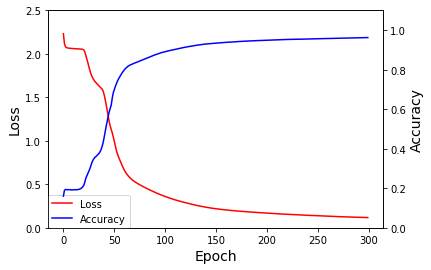

In [111]:
# lr 2e-5 -> 2e-4

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(loss_hist,
         color='r', label="Loss")
ax2.plot(train_hist, color='b',
        label="Accuracy")
 
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
ax1.legend(handler1 + handler2, label1 + label2, loc=3, borderaxespad=0.)
ax1.set_xlabel('Epoch', fontsize=14)
ax1.set_ylabel('Loss', fontsize=14)
ax2.set_ylabel('Accuracy', fontsize=14)
 
ax1.set_ylim([0, 2.5])
ax2.set_ylim([0, 1.1])